# Utilities 

First, we defined all common imports and functions used across the code.

In [21]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline

snapshots = []

def read_json_file(file_path):
    print(f"Reading file: {file_path}")
    with open(file_path, "r", encoding="utf-8") as file:
        return json.load(file)
    
def get_snapshots():
    if len(snapshots) > 0:
        print("Returning existing snapshots")
        return snapshots

    print("Reading snapshots from OS")
    for root, _, files in os.walk("../snapshots"):
        for file in files:
            if file.endswith(".json"):
                file_path = os.path.join(root, file)
                snapshots.append(read_json_file(file_path))
    
    return snapshots
    
def draw_pie_chart(sizes, labels, title):
    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%')
    ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
    ax.set_title(title)
    plt.show()

# Research Question 1

What is the typical structure of conversations between developers and ChatGPT?   
How many turns does it take on average to reach a conclusion?

# Approach 1: Simple Issues Categorization

In this approach, ..

In [22]:
def categorize_conversation(prompt, answer):
    prompt = prompt.lower()
    answer = answer.lower()

    if "bug" in prompt or "error" in answer:
        category = "Bug"
    elif "feature" in prompt or "implement" in answer:
        category = "Feature Request"
    elif "how to" in prompt or "why" in answer:
        category = "Theoretical Question"
    else:
        category = "Other"

    return category


def process_json_files_rq1_simple():
    categories_count = {
        "Bug": 0,
        "Feature Request": 0,
        "Theoretical Question": 0,
        "Other": 0,
    }

    for data in get_snapshots():
        for source in data.get("Sources", []):
            chatgpt_sharing = source.get("ChatgptSharing", [])
            for sharing in chatgpt_sharing:
                for conversation in sharing.get("Conversations", []):
                    prompt = conversation.get("Prompt", "")
                    answer = conversation.get("Answer", "")
                    category = categorize_conversation(prompt, answer)
                    categories_count[category] += 1

    return categories_count


print("Starting analysis...")
result_rq1_simple = process_json_files_rq1_simple()
print("\nAnalysis completed.\n")

Starting analysis...
Reading snapshots from OS
Reading file: ../snapshots\snapshot_20230727\20230727_195816_hn_sharings.json
Reading file: ../snapshots\snapshot_20230727\20230727_195927_pr_sharings.json
Reading file: ../snapshots\snapshot_20230727\20230727_195941_issue_sharings.json
Reading file: ../snapshots\snapshot_20230727\20230727_195954_discussion_sharings.json
Reading file: ../snapshots\snapshot_20230727\20230727_200003_commit_sharings.json
Reading file: ../snapshots\snapshot_20230727\20230727_200102_file_sharings.json
Reading file: ../snapshots\snapshot_20230803\20230803_093947_pr_sharings.json
Reading file: ../snapshots\snapshot_20230803\20230803_094705_issue_sharings.json
Reading file: ../snapshots\snapshot_20230803\20230803_094811_discussion_sharings.json
Reading file: ../snapshots\snapshot_20230803\20230803_095317_commit_sharings.json
Reading file: ../snapshots\snapshot_20230803\20230803_103605_file_sharings.json
Reading file: ../snapshots\snapshot_20230803\20230803_105332_

### Results: Simple Issues Categorization

Results:

	Total conversations: 153556
	Bug: 15164
	Feature Request: 14719
	Theoretical Question: 4487
	Other: 119186


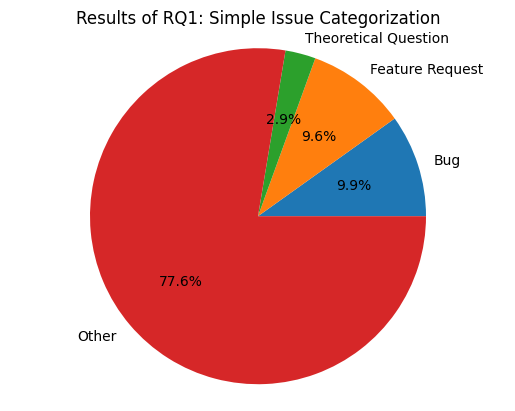

In [23]:
print("Results:")
print("\n\tTotal conversations:", sum(result_rq1_simple.values()))

for category, count in result_rq1_simple.items():
    print(f"\t{category}: {count}")

draw_pie_chart(
    result_rq1_simple.values(), 
    result_rq1_simple.keys(), 
    "Results of RQ1: Simple Issue Categorization"
)

### Approach 2: Issues categorization via Model

In this approach, we 

In [25]:
# Load and prepare the machine learning model
print("Training model...")
df = pd.read_csv("training_set.csv")
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42
)
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)
print("Training model complete.\n")


def combined_categorization(prompt, answer, model, vectorizer):
    combined_text = prompt + " " + answer
    transformed_text = vectorizer.transform([combined_text])
    return model.predict(transformed_text)[0]

def process_json_files_rq1_model(model, vectorizer):
    categories_count = {
        "Bug": 0,
        "Feature Request": 0,
        "Theoretical Question": 0,
        "Other": 0,
    }
    results = []

    for data in get_snapshots():
        for source in data.get("Sources", []):
            chatgpt_sharing = source.get("ChatgptSharing", [])
            for sharing in chatgpt_sharing:
                for conversation in sharing.get("Conversations", []):
                    prompt = conversation.get("Prompt", "")
                    answer = conversation.get("Answer", "")
                    category = combined_categorization(
                        prompt, answer, model, vectorizer
                    )
                    categories_count[category] += 1

                    # Only add to results if category is not 'Other'
                    if category != "Other":
                        results.append(
                            {
                                "prompt": prompt,
                                "answer": answer,
                                "category": category,
                            }
                        )

    return categories_count, results


print("Starting analysis...")
model_categories_count, model_categorized_data = process_json_files_rq1_model(model, vectorizer)
print("\nAnalysis completed.\n")

Training model...
Training model complete.

Starting analysis...
Returning existing snapshots

Analysis completed.



### RQ1 results of approach 2: Model Categorization

In [2]:
print("Results:")
print("\n\tTotal conversations:", len(model_categorized_data))

print(model_categorized_data)
print(model_categories_count)

for category, count in model_categories_count.items():
    print(f"\t{category}: {count}")

Results:


NameError: name 'model_categorized_data' is not defined

# Research Question 2

What is the typical structure of conversations between developers and ChatGPT?   
How many turns does it take on average to reach a conclusion?